# Project Description

Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value.

Rusty Bargain is interested in:
- the quality of the prediction
- the speed of the prediction
- the time required for training

## Project instructions
1. Download and look at the data.
2. Train different models with various hyperparameters (You should make at least two different models, but more is better. Remember, various implementations of gradient boosting don't count as different models.) The main point of this step is to compare gradient boosting methods with random forest, decision tree, and linear regression.
3. Analyze the speed and quality of the models.

   
## Data description
**Features**
- DateCrawled — date profile was downloaded from the database
- VehicleType — vehicle body type
- RegistrationYear — vehicle registration year
- Gearbox — gearbox type
- Power — power (hp)
- Model — vehicle model
- Mileage — mileage (measured in km due to dataset's regional specifics)
- RegistrationMonth — vehicle registration month
- FuelType — fuel type
- Brand — vehicle brand
- NotRepaired — vehicle repaired or not
- DateCreated — date of profile creation
- NumberOfPictures — number of vehicle pictures
- PostalCode — postal code of profile owner (user)
- LastSeen — date of the last activity of the user

**Target**
- Price — price (Euro)


# TOC

- [Project Description](#Project-Description)
    * [Project instructions](#Project-instructions)
    * [Data description](#Data-description)
- [TOC](#TOC)
- [1. Data Importing and Inspection](#1.-Data-Importing-and-Inspection)
- [2. Data Preprocessing](#2.-Data-Preprocessing)
    * [2.1. Dropping cols and removing outliers](#2.1.-Dropping-cols-and-removing-outliers)
    * [2.2. Fill in missing values](#2.2.-Fill-in-missing-values)
    * [2.3. Feature encoding](#2.3.-Feature-encoding)
        + [2.3.1. One Hot encoding](#2.3.1.-One-Hot-encoding)
        + [2.3.2. Ordinal encoding](#2.3.2.-Ordinal-encoding)
    * [2.4. Splitting data](#2.4.-Splitting-data)
- [3. Model training and comparison](#3.-Model-training-and-comparison)
    * [3.1. Baseline model](#3.1.-Baseline-model)
    * [3.2. Random Forest Regressor](#3.2.-Random-Forest-Regressor)
        + [3.2.1. Standard RFC for Benchmarking](#3.2.1.-Standard-RFC-for-Benchmarking)
        + [3.2.2. RFC Hyperparameter Tuning](#3.2.2.-RFC-Hyperparameter-Tuning)
    * [3.3. LightGBM](#3.3.-LightGBM)
        + [3.3.1. Baseline standardregressor](#3.3.1.-Baseline-standardregressor)
        + [3.3.2. Hyperparameter Tuning](#3.3.2.-Hyperparameter-Tuning)
    * [3.4. Catboost](#3.4.-Catboost)
        + [3.4.1. Catboost Baseline](#3.4.1.-Catboost-Baseline)
        + [3.4.2. Catboost Hyperparameter Tuning](#3.4.2.-Catboost-Hyperparameter-Tuning)
- [4. Conclusion](#4.-Conclusion)

# 1. Data Importing and Inspection

In [1]:
import warnings 
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

warnings.filterwarnings("ignore")  

import joblib

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor, cv, Pool


from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

# Activate autocomplete
%config Completer.use_jedi = False

RANDOM_STATE = 42

C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [3]:
try:
    df = pd.read_csv('./datasets/car_data.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/car_data.csv')
display(df.head())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [4]:
df.nunique()

DateCrawled          15470
Price                 3731
VehicleType              8
RegistrationYear       151
Gearbox                  2
Power                  712
Model                  250
Mileage                 13
RegistrationMonth       13
FuelType                 7
Brand                   40
NotRepaired              2
DateCreated            109
NumberOfPictures         1
PostalCode            8143
LastSeen             18592
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Mileage                  0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

> **Observations:**
> -  DateCrawled does not provide any information to the target because they are not related. (Because DateCrwawled just gives information when the datapoint was downloaded from the database), same applies for RegistrationMonth, LastSeen.  
\-\> Therefore they will be dropped
> - PostalCode are unique values and would confuse the model
> - There are missing values in the data but only for the strings, all numerical values are complete

In [7]:
df.describe()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [8]:
df['NumberOfPictures'].max()

0

> **Observations:**
> - The collumn NumberOfPictures can be dropped because all entries are zero
> - The dataset contains outliers and invalid data (eg. registration year)

# 2. Data Preprocessing

## 2.1. Dropping cols and removing outliers
> In this step the collumns which are not providing benefficial value to the project will be dropped.

In [9]:
# Dropping unneccessary cols
toDrop = ['DateCrawled', 'DateCreated', 'PostalCode', 'LastSeen', 'NumberOfPictures']
df = df.drop(toDrop, axis=1)
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


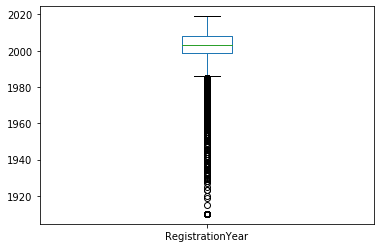

In [10]:
# Removing all cars with registration which is more than 2 years ahead (depending on country registrated anually or every two)
# And older than 1886 (Year of first car built for considering oldhimers)
df = df.query('1886 <= RegistrationYear <= 2023')
df.RegistrationYear.plot(kind='box');

> Age seems to be legit now

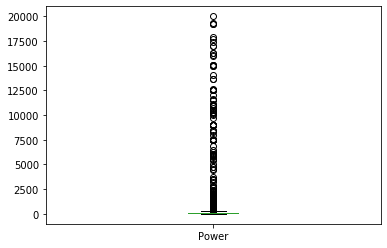

In [11]:
# Removing cars with zero Horsepowers because faulty entrie, same for cars with more than 800  
df.Power.plot(kind='box')
df = df.query('0 < Power <= 800')

## 2.2. Fill in missing values
> All missing values are in the categorical columns and strings.   
> They will be investigated in detail and filled in this step. 

In [12]:
# Filling missing categorical values
df.fillna('unknown', inplace=True)

In [13]:
# Investigating fuel types
df.FuelType.value_counts()

petrol      196178
gasoline     90647
unknown      21147
lpg           4910
cng            504
hybrid         207
other          102
electric        78
Name: FuelType, dtype: int64

> - Petrol and gasoline are the same thing, one is american english, the other one british english, thus they will be merged.  
> - It is Suspicious that there are no disel cars, maybe the unknown category contains them. Therefore it need to be spoken with the data engineer

In [14]:
df.FuelType.replace('petrol', 'gasoline', inplace=True)
df.FuelType.value_counts()

gasoline    286825
unknown      21147
lpg           4910
cng            504
hybrid         207
other          102
electric        78
Name: FuelType, dtype: int64

## 2.3. Feature encoding
> In this chapter the categorical features will be encoded in preparation for the model training.  
> They will be ordinal encoded for Random Forests, LightGBM, CatBoost and OHE for XGBoost

In [15]:
# Assembling Categorical cols to encode
categorical_features = [
    'VehicleType',
    'Gearbox', 
    'Model',
    'FuelType', 
    'Brand',
    'NotRepaired', 
]

### 2.3.1. One Hot encoding
> In this step the df has been onehot encoded for later training of XGBoost

In [16]:
# Investigating number of unique categories
df[categorical_features].nunique()

VehicleType      9
Gearbox          3
Model          250
FuelType         7
Brand           40
NotRepaired      3
dtype: int64

> Brand and Model will be dropped for ohe because the dataframe would get too large to process it effectively

In [17]:
# Dropping the cols whith too many categories
df_ohe = df.drop(['Model', 'Brand'], axis=1)

# OHE the remaining categroeis
df_ohe = pd.get_dummies(df_ohe)

df_ohe.head()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,VehicleType_bus,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,...,FuelType_cng,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_unknown,NotRepaired_no,NotRepaired_unknown,NotRepaired_yes
1,18300,2011,190,125000,5,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
2,9800,2004,163,125000,8,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,1500,2001,75,150000,6,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
4,3600,2008,69,90000,7,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
5,650,1995,102,150000,10,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1


### 2.3.2. Ordinal encoding
> In this step the data has been encoded ordinal to ease later model training

In [18]:
# Copying df to not modify orginal data
df_ord = df.copy()
df_ord[categorical_features] = OrdinalEncoder().fit_transform(df_ord[categorical_features])
df_ord.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired
1,18300,2.0,2011,1.0,190,227.0,125000,5,2.0,1.0,2.0
2,9800,6.0,2004,0.0,163,117.0,125000,8,2.0,14.0,1.0
3,1500,5.0,2001,1.0,75,116.0,150000,6,2.0,38.0,0.0
4,3600,5.0,2008,1.0,69,101.0,90000,7,2.0,31.0,0.0
5,650,4.0,1995,1.0,102,11.0,150000,10,2.0,2.0,2.0


## 2.4. Splitting data
> In this chapter the differet datasets have been splitted into test and train data with a ratio of 6/4

In [19]:
# Splitting OHE DF Needed for XGBoost (But for timereasons not covered in the project)
X_train_ohe, X_test_ohe, y_train_ohe, y_test_ohe = train_test_split(
    df_ohe.drop(['Price'], axis=1), df_ohe.loc[:, 'Price'], 
    test_size=.4, random_state=RANDOM_STATE
)

# Splitting Ordinal encoded df
X_train_ord, X_test_ord, y_train_ord, y_test_ord = train_test_split(
    df_ord.drop(['Price'], axis=1), df_ord.loc[:, 'Price'], 
    test_size=.4, random_state=RANDOM_STATE
)

# Splitting  df
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['Price'], axis=1), df.loc[:, 'Price'], 
    test_size=.4, random_state=RANDOM_STATE
)

# 3. Model training and comparison
> In this chapter the different Regressors have been built and optimized.   
> To evaluate the models first a scorer has been built because sklearn is not supplying a prebuilt rmse metric

In [20]:
# Creating helper functions

def rmse_loss_fct(y, y_pred):
    '''Helper function which calculates the RMSE
    args:
        y: list/np arrray with true targets
        y_pred: list/np.array with model prediction
    returns:
        rmse value'''
    return mean_squared_error(y, y_pred)**0.5

# Create scorer
rmse = make_scorer(rmse_loss_fct, greater_is_better=False)

## 3.1. Baseline model
> In order to check if the algorithms are actually learning, a dummy regressor (in this case a mean dummy) has been built  
> Due to the project description a linear model has built as well as baseline because the description says, that linear regression is not performing well for this problem

In [21]:
# Creating Baseline mean dummies
dummy_reg_test = DummyRegressor(strategy='mean')
dummy_reg_train = DummyRegressor(strategy='mean')

dummy_reg_test.fit(X_test_ohe, y_test_ohe)
dummy_reg_train.fit(X_train_ohe, y_train_ohe)

print(f'Baseline training: {rmse_loss_fct(dummy_reg_test.predict(X_train_ohe), y_train_ohe)}')
print(f'Baseline test: {rmse_loss_fct(dummy_reg_test.predict(X_test_ohe), y_test_ohe)}')

Baseline training: 4597.670889965335
Baseline test: 4581.104357818362


In [22]:
# Creating Baseline mean dummies
linear_model = LinearRegression()
linear_model.fit(X_train_ohe, y_train_ohe)
y_pred_lin = linear_model.predict(X_test_ohe)
print(f'Baseline linear model: {rmse_loss_fct(y_pred_lin, y_test_ohe)}')

Baseline linear model: 3004.8689256118346


## 3.2. Random Forest Regressor

### 3.2.1. Standard RFC for Benchmarking
> In this Step the baseline for RFRs has been created by using a standard model as well as the cross validation mean

In [23]:
rf_reg = RandomForestRegressor(random_state=RANDOM_STATE)

rf_reg_cv = cross_val_score(rf_reg,
                            X_train_ord,
                            y_train_ord,
                            cv=10,
                            scoring=rmse,
                            verbose=0
                           )
print(f'Crossfold RMSE mean for Standard RFC regressor: {abs(rf_reg_cv.mean())}')

C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Crossfold RMSE mean for Standard RFC regressor: 1815.0537776878875


In [24]:
# Evaluating the standart rfr model
standart_rfr = RandomForestRegressor(random_state=RANDOM_STATE)
standart_rfr.fit(X_train_ord, y_train_ord)
y_rft = standart_rfr.predict(X_test_ord)
print(f'RMSE of standard Random Forest: {rmse_loss_fct(y_test_ord, y_rft)}')

C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RMSE of standard Random Forest: 1811.691785657868


> **Observation:**
> - Standard RFC is alerady much better than the Baseline model

### 3.2.2. RFC Hyperparameter Tuning
> For further improving the model, the hyperparameter have been tuned by using random search and grid search

In [25]:
# Random searc
rfr_reg = RandomForestRegressor(random_state=RANDOM_STATE)

# Assembling param Grid for Random grid search
param_grid_rfr_rand = {
    'n_estimators': [50,100, 150],
    'max_depth': [2, 5, 10],
    'bootstrap': [True, False],
    'min_samples_leaf': [1,2,5]
}

rand_search_rfr = RandomizedSearchCV(
    estimator=rfr_reg,
    param_distributions=param_grid_rfr_rand,
    n_iter=25,
    scoring=rmse,
    verbose=2,
    random_state=RANDOM_STATE,
    return_train_score=True,
    n_jobs=-1
)

rand_search_rfr.fit(X_train_ord, y_train_ord)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  9.6min finished


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_st

In [26]:
# Evluating the best estimator
y_pred = rand_search_rfr.best_estimator_.predict(X_test_ord)
print(f'RMSE of best estimator: {rmse_loss_fct(y_test_ord, y_pred)}')

RMSE of best estimator: 1985.0019023370567


>**Observations:**
> - The Standard RFR shows better accuracy than the best random estimator. This is not representative because the standardregressor could be overfitted
> - The RFR is significant better than the baseline dummymodell

## 3.3. LightGBM

### 3.3.1. Baseline standardregressor
> In this Step the baseline for LightGBMs has been created by using a standard model as well as the cross validation mean

In [27]:
# Evaluating cv validation
light_cv_benchmarking = lgb.LGBMRegressor(metric='rmse')
light_reg_cv = cross_val_score(light_cv_benchmarking,
                               X_train_ord,
                               y_train_ord,
                               cv=10,
                               scoring=rmse,
                               verbose=1,
                               n_jobs=-1
                           )
print(f'Crossfold RMSE mean for Standard LightGBM regressor: {abs(light_reg_cv.mean())}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Crossfold RMSE mean for Standard LightGBM regressor: 1824.3915931962074


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    8.3s finished


In [28]:
# Evaluating perfomance of standard LBG
light_cv_standard = lgb.LGBMRegressor(metric='rmse')
light_cv_standard.fit(X_train_ord, y_train_ord)
y_test_light = light_cv_standard.predict(X_test_ord)
print(f'RMSE of standard LightGBM: {rmse_loss_fct(y_test_ord, y_test_light)}')

RMSE of standard LightGBM: 1822.514232941178


> **Observations:**
> - The Performance of the lightGBM is more or less equal to the performance of the random forests regressor (At least during cross validation)

### 3.3.2. Hyperparameter Tuning
> For further improving the model, the hyperparameter have been tuned by using random search and grid search

In [29]:
# Assembling Param gid and regressor
light_rand_reg = lgb.LGBMRegressor(metric='rmse')

param_grid_light = {
    'num_iterations': [100,500,800,1000],
    'max_depth': [5, 10, 20],
    'learning_rate': [0.05, 0.1, 0.2]
}

rand_search_light = RandomizedSearchCV(
    estimator=light_rand_reg,
    param_distributions=param_grid_light,
    n_iter=75,
    scoring=rmse,
    verbose=2,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rand_search_light.fit(X_train_ord, y_train_ord)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\sklearn\model_selection\_search.py:266: UserWarning: The total space of parameters 36 is smaller than n_iter=75. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  6.0min finished
C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead o

RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=LGBMRegressor(boosting_type='gbdt',
                                           class_weight=None,
                                           colsample_bytree=1.0,
                                           importance_type='split',
                                           learning_rate=0.1, max_depth=-1,
                                           metric='rmse', min_child_samples=20,
                                           min_child_weight=0.001,
                                           min_split_gain=0.0, n_estimators=100,
                                           n_jobs=-1, num_leaves=31,
                                           objective=None, random_state=None...
                                           silent=True, subsample=1.0,
                                           subsample_for_bin=200000,
                                           subsample_freq=0),
                   iid

In [30]:
print(f'RMSE for best LBGoost regessor score from random search with cv: {abs(rand_search_light.best_score_)}')

# Evluating the best estimator
y_pred_lgb = rand_search_light.best_estimator_.predict(X_test_ord)
print(f'RMSE for best regressor on thest data: {rmse_loss_fct(y_test_ord, y_pred_lgb)}')

RMSE for best LBGoost regessor score from random search with cv: 1709.2171685972862
RMSE for best regressor on thest data: 1684.4731795233922


> **Observations:**
> - The Best regressor is significant better than the baseline AND the standard LGBoost regressor
> - Futher Parameter tuning needed


In [31]:
# Investigating parameter ranges
print(f'Best params: {rand_search_light.best_params_}')

Best params: {'num_iterations': 1000, 'max_depth': 20, 'learning_rate': 0.1}


In [32]:
# Aggregating Grid in Parameter range
param_grid_lgb_grid = {
    'num_iterations': [1000, 1250, 1500],
    'max_depth': [15, 20, 25],
    'learning_rate': [.1]
}

lgb_grid_reg = lgb.LGBMRegressor(metric='rmse')

grid_search_lgb = GridSearchCV(estimator=lgb_grid_reg,
                               param_grid=param_grid_lgb_grid,
                               n_jobs=-1,
                               scoring=rmse,
                               error_score=0,
                               verbose=2,
                               return_train_score=True
                              )


grid_search_lgb.fit(X_train_ord, y_train_ord)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  8.2min finished
C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


GridSearchCV(cv='warn', error_score=0,
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, metric='rmse',
                                     min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=None,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='warn', n_jobs=-1,
             param_grid={'learning_rate': [0.1], 'max_depth': [15, 20, 25],
                         'num_iterations': [1000, 1250, 1

In [33]:
print(f'RMSE for best LBGoost regessor score from random search with cv: {abs(rand_search_light.best_score_)}')

# Evluating the best estimator
y_pred_lgb = grid_search_lgb.best_estimator_.predict(X_test_ord)
print(f'RMSE for best regressor on thest data: {rmse_loss_fct(y_test_ord, y_pred_lgb)}')

RMSE for best LBGoost regessor score from random search with cv: 1709.2171685972862
RMSE for best regressor on thest data: 1672.975981006591


> **Observations:**
> - The Hyperparameter tunig improved the results a little but not significantly

## 3.4. Catboost

### 3.4.1. Catboost Baseline

In [34]:
%%time
# Benchmarking catboost cross validation 
cb_cv = CatBoostRegressor(cat_features=categorical_features,
                          metric_period=50,
                          loss_function="RMSE",
                          eval_metric="RMSE",
                          random_seed=42
                         )

cv_score_cb = cross_validate(cb_cv,
                             X_train,
                             y_train,
                             scoring=rmse,
                             cv=5,
                             return_train_score=True,
                             n_jobs=-1
                            )
mean_cv_cb = abs(cv_score_cb['test_score'].mean())
print(f'Crossvalidation RSME mean for Catboost: {mean_cv_cb}')

Crossvalidation RSME mean for Catboost: 1743.359742423243
Wall time: 12min 18s


In [35]:
%%time 
# Benchmarking a standard CatBoostRegressor
cb_benchmarking = CatBoostRegressor(cat_features=categorical_features,
                                    metric_period=50,
                                    loss_function="RMSE",
                                    eval_metric="RMSE",
                                    #task_type="GPU",
                                    random_seed=42
                                      )
cb_benchmarking.fit(X_train, y_train)
y_pred_cb = cb_benchmarking.predict(X_test)

print(f'RMSE for best regressor on thest data: {rmse_loss_fct(y_test, y_pred_cb)}')

Learning rate set to 0.099154
0:	learn: 4306.0179326	total: 406ms	remaining: 6m 45s
50:	learn: 1965.4728298	total: 12.6s	remaining: 3m 53s
100:	learn: 1879.9999021	total: 24.5s	remaining: 3m 37s
150:	learn: 1832.1813293	total: 37.3s	remaining: 3m 29s
200:	learn: 1804.8473874	total: 49.5s	remaining: 3m 16s
250:	learn: 1781.6953933	total: 1m 5s	remaining: 3m 16s
300:	learn: 1763.2839689	total: 1m 20s	remaining: 3m 5s
350:	learn: 1750.1030733	total: 1m 33s	remaining: 2m 52s
400:	learn: 1736.3245019	total: 1m 45s	remaining: 2m 37s
450:	learn: 1724.4894340	total: 1m 56s	remaining: 2m 22s
500:	learn: 1716.0076630	total: 2m 7s	remaining: 2m 7s
550:	learn: 1707.2508329	total: 2m 16s	remaining: 1m 51s
600:	learn: 1699.8153065	total: 2m 26s	remaining: 1m 37s
650:	learn: 1693.5608575	total: 2m 35s	remaining: 1m 23s
700:	learn: 1686.8217455	total: 2m 45s	remaining: 1m 10s
750:	learn: 1680.2770526	total: 2m 55s	remaining: 58.2s
800:	learn: 1674.3612859	total: 3m 4s	remaining: 45.9s
850:	learn: 1668

### 3.4.2. Catboost Hyperparameter Tuning

In [36]:
%%time
# Assembling Param gid and regressor for random search
cat_rand_reg = CatBoostRegressor(cat_features=categorical_features,
                                 metric_period=50,
                                 loss_function="RMSE",
                                 eval_metric="RMSE",
                                 #task_type="GPU",
                                 random_seed=42
                                )

param_grid_cat = {'learning_rate': [0.05, 0.1],
                  'depth': [4, 6],
                  'l2_leaf_reg': [3, 5, 7],
                  'iterations': [500, 750, 1000]
                 }

randomized_search_result = cat_rand_reg.randomized_search(param_grid_cat,
                                                          X=X_train,
                                                          y=y_train,
                                                          cv=3,
                                                          n_iter=5,
                                                          partition_random_seed=RANDOM_STATE)


0:	learn: 6324.8238633	test: 6326.1735931	best: 6326.1735931 (0)	total: 132ms	remaining: 1m 38s
50:	learn: 2356.4476029	test: 2360.5113168	best: 2360.5113168 (50)	total: 6.18s	remaining: 1m 24s
100:	learn: 2085.0369906	test: 2084.5103796	best: 2084.5103796 (100)	total: 13s	remaining: 1m 23s
150:	learn: 2013.7267704	test: 2012.8748477	best: 2012.8748477 (150)	total: 19.8s	remaining: 1m 18s
200:	learn: 1971.8259255	test: 1972.8423519	best: 1972.8423519 (200)	total: 25.5s	remaining: 1m 9s
250:	learn: 1942.4665273	test: 1944.6743966	best: 1944.6743966 (250)	total: 31.1s	remaining: 1m 1s
300:	learn: 1921.1479850	test: 1924.7938153	best: 1924.7938153 (300)	total: 36.3s	remaining: 54.1s
350:	learn: 1903.6412143	test: 1909.7113656	best: 1909.7113656 (350)	total: 41.3s	remaining: 46.9s
400:	learn: 1887.7848567	test: 1895.1965319	best: 1895.1965319 (400)	total: 47s	remaining: 40.9s
450:	learn: 1875.1761307	test: 1884.6723737	best: 1884.6723737 (450)	total: 52.2s	remaining: 34.6s
500:	learn: 1864

In [37]:
randomized_search_result['params']

{'depth': 6, 'l2_leaf_reg': 3, 'iterations': 1000, 'learning_rate': 0.1}

In [39]:
cat_rand_test = CatBoostRegressor(cat_features=categorical_features,
                                 metric_period=50,
                                 loss_function="RMSE",
                                 eval_metric="RMSE",
                                 #task_type="GPU",
                                 random_seed=42,
                                 **randomized_search_result['params']
                                )
cat_rand_test.fit(X_train, y_train)
ypred_cat = cat_rand_test.predict(X_test)
print(f'Best RSME of random catboost estimator: {rmse_loss_fct(y_test, ypred_cat)}')

0:	learn: 4303.5799663	total: 231ms	remaining: 3m 50s
50:	learn: 1961.6370368	total: 10.9s	remaining: 3m 23s
100:	learn: 1873.1206153	total: 22.5s	remaining: 3m 20s
150:	learn: 1827.5261485	total: 33.5s	remaining: 3m 8s
200:	learn: 1796.1538604	total: 45.4s	remaining: 3m
250:	learn: 1774.9658471	total: 56.5s	remaining: 2m 48s
300:	learn: 1757.0388351	total: 1m 7s	remaining: 2m 36s
350:	learn: 1743.0394304	total: 1m 18s	remaining: 2m 25s
400:	learn: 1730.3538805	total: 1m 30s	remaining: 2m 15s
450:	learn: 1720.5237118	total: 1m 43s	remaining: 2m 5s
500:	learn: 1711.0866902	total: 1m 56s	remaining: 1m 56s
550:	learn: 1702.7667649	total: 2m 9s	remaining: 1m 45s
600:	learn: 1694.8873671	total: 2m 22s	remaining: 1m 34s
650:	learn: 1687.8808300	total: 2m 33s	remaining: 1m 22s
700:	learn: 1680.5329656	total: 2m 44s	remaining: 1m 10s
750:	learn: 1673.6075042	total: 2m 55s	remaining: 58.1s
800:	learn: 1668.8993340	total: 3m 8s	remaining: 46.7s
850:	learn: 1662.7178204	total: 3m 20s	remaining: 3

> Due to time consuming training, gridsearch has not been carried out  
> **Observations:**
> - The RMSE is significant lower than the otter boost algorithms as well as the baseline

# 4. Conclusion

In [40]:
# Aggregating cross validation results
scores = {
    'catboost': rmse_loss_fct(y_test, ypred_cat),
    'lightgbm': abs(light_reg_cv.mean()) ,
    'Random_forest': mean_cv_cb,
    'Linreg': rmse_loss_fct(y_pred_lin, y_test_ohe),
    'Dummy': rmse_loss_fct(dummy_reg_test.predict(X_test_ohe), y_test_ohe)
}
scores

{'catboost': 1145.590061992457,
 'lightgbm': 1824.3915931962074,
 'Random_forest': 1743.359742423243,
 'Linreg': 3004.8689256118346,
 'Dummy': 4581.104357818362}

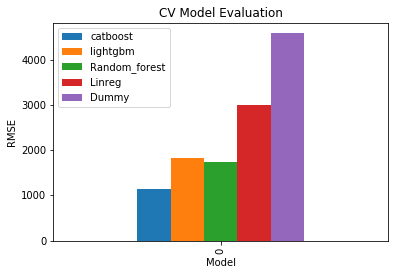

In [41]:
# Plotting Cross validation results
pd.DataFrame(scores, index=[0]) \
  .plot(kind='bar', 
        title='CV Model Evaluation',
        xlabel='Model',
        ylabel='RMSE');

**During the project the following steps have been carried out:**
- Data inspection
- Data preprocessing
    - Sort out unnecessary features
    - Filling missing values 
    - Clean data
- Model Training
    - Baseline for evaluation
    - Random Forest regressor
    - LightGBM
    - Catboost  
 
 
 For every model first the general performance has been evaluated by cross validation and a standard model. 
 In the next step a random grid search has been carried out before a final grid search and eavaluation of the best found model.
 
 Comparing the cross validation values it can be seen, that the catboost algorithm is by far the best fit for the given problem.
 The same is visible in the final results.